# Feature Extraction

## Create path to file for csv in the last cell to hold results before running

In [1]:
import warnings
warnings.simplefilter('ignore', FutureWarning)
import numpy as np
import pandas as pd
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.visualize import display_instances
from objectmapping import ObjectMapping
from mrcnn_classes import class_names
from itertools import permutations
from collections import defaultdict
import os

Using TensorFlow backend.


In [2]:
%%time
# define the test configuration
class TestConfig(Config):
    NAME = "test"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 80

# define the model
rcnn = MaskRCNN(mode='inference', model_dir='./', config=TestConfig())

# load coco model weights
rcnn.load_weights('../data/mask_rcnn_coco.h5', by_name=True);

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead
CPU times: user 10.6 s, sys: 713 ms, total: 11.3 s
Wall time: 11.2 s


In [3]:
def area_from_box(h1, w1, h2, w2):
        return abs(h1-h2)*abs(w1-w2)
    
def depth_response(a, b):
    while True:
        print('\n')
        print(f"Are objects {a} and {b} at the same depth level?")        
        print("0: no")
        print("1: yes")
        response = input()
        if response == '1':
            break
        elif response == '0':
            break
    return int(response)

def frontbehind_response(a, b):
    while True:
        print('\n')
        print(f"If touching, is object {a} in front of or behind {b}?")        
        print("0: behind")
        print("1: in front")
        print("2: neither or not touching")
        response = input()
        if response == '0':
            break
        elif response == '1':
            break
        elif response == '2':
            break
    return int(response)

def invson_response(a, b):
    while True:
        print('\n')
        print(f"Is object {a} in object {b}?")        
        print("0: no")
        print("1: yes")
        response = input()
        if response == '0':
            break
        elif response == '1':
            break
    return int(response)


In [4]:
#load image
imagefile = '../images/mod_people_on_car1.jpg'
img = load_img(imagefile)
img_array = img_to_array(img)
# make prediction
results = rcnn.detect([img_array], verbose=False)
# get dictionary for first prediction
r = results[0]

# instantiate object
x = ObjectMapping(imagefile, r, class_names)

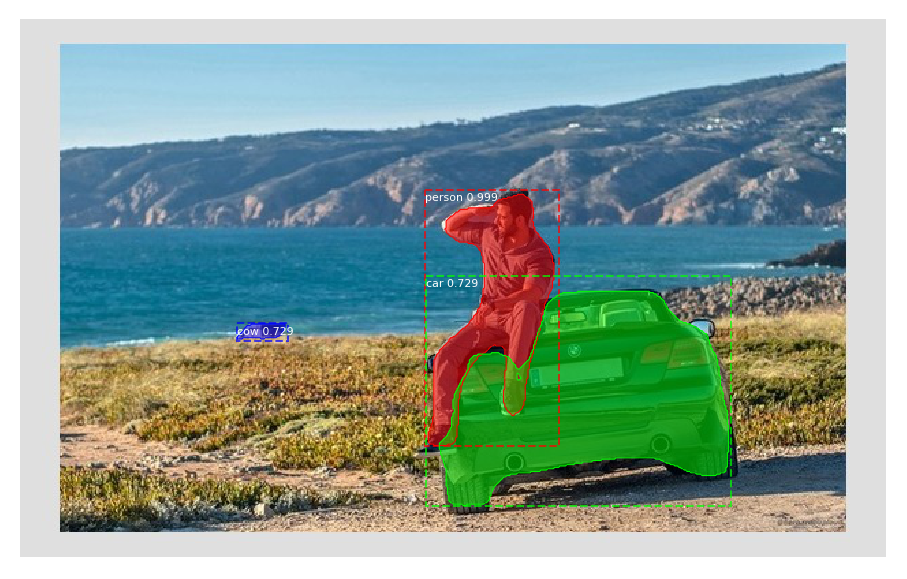



Are objects 1 and 2 at the same depth level?
0: no
1: yes
1




If touching, is object 1 in front of or behind 2?
0: behind
1: in front
2: neither or not touching
1


Is object 1 in object 2?
0: no
1: yes
0


Are objects 1 and 3 at the same depth level?
0: no
1: yes
0


Are objects 2 and 1 at the same depth level?
0: no
1: yes
1




If touching, is object 2 in front of or behind 1?
0: behind
1: in front
2: neither or not touching
0


Is object 2 in object 1?
0: no
1: yes
0


Are objects 2 and 3 at the same depth level?
0: no
1: yes
0


Are objects 3 and 1 at the same depth level?
0: no
1: yes
0


Are objects 3 and 2 at the same depth level?
0: no
1: yes
0


In [12]:
if x.total_objects <= 1:
            print('Not enough objects detected.')            
else:
    image_data = defaultdict(list)
    object_bb = {}
    object_mb = {}
    areas_bb = {}
    areas_mb = {}
    object_pixels = {}
    ids = []
    for i in range(1, x.total_objects+1):
        object_bb[i] = x.get_box(i)
        object_mb[i] = x.mass_box(i)
        object_pixels[i] = x.mask_pixel_count(i)
        ids.append(i)
        areas_bb[i] = area_from_box(*object_bb[i])
        areas_mb[i] = area_from_box(*object_mb[i])

    image_area = x.img_height*x.img_width
    ptot_bb_area = sum(areas_bb.values())
    ptot_mb_area = sum(areas_mb.values())
    ptot_mask_pixels = sum(object_pixels.values())
    
    display_instances(img_array, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])
    object_combos = permutations(ids, r=2)
    for a, b in object_combos:
        # Overall image data
        image_data['filename'].append(x.filename)
        image_data['image height'].append(x.img_height)
        image_data['image width'].append(x.img_width)
        image_data['total objects'].append(x.total_objects)
        image_data['% total pixels'].append(ptot_mask_pixels/image_area)
        image_data['% total bb area'].append(ptot_bb_area/image_area)
        image_data['% total mb area'].append(ptot_mb_area/image_area)
        
        # Object A data relationship to image
        image_data['objectA'].append(x.object_class(a))
        image_data['A % bb area'].append(areas_bb[a]/image_area)
        image_data['A % mb area'].append(areas_mb[a]/image_area)
        image_data['A diff bbmb image area'].append(image_data['A % bb area'][-1]-\
                                                  image_data['A % mb area'][-1])
        image_data['A % bb area of sum bb'].append(areas_bb[a]/ptot_bb_area)
        image_data['A % mb area of sum mb'].append(areas_mb[a]/ptot_mb_area)
        image_data['A diff bbmb box area'].append(image_data['A % bb area of sum bb'][-1]-\
                                                  image_data['A % mb area of sum mb'][-1])
        image_data['A % top bb'].append(object_bb[a][0]/x.img_height)
        image_data['A % left bb'].append(object_bb[a][1]/x.img_width)
        image_data['A % bottom bb'].append(object_bb[a][2]/x.img_height)
        image_data['A % right bb'].append(object_bb[a][3]/x.img_width)
        image_data['A % top mb'].append(object_mb[a][0]/x.img_height)
        image_data['A % left mb'].append(object_mb[a][1]/x.img_width)
        image_data['A % bottom mb'].append(object_mb[a][2]/x.img_height)
        image_data['A % right mb'].append(object_mb[a][3]/x.img_width)
        image_data['A % pixels of image area'].append(object_pixels[a]/image_area)
        image_data['A % pixels of bb area'].append(object_pixels[a]/areas_bb[a])
        image_data['A % pixels of mb area'].append(object_pixels[a]/areas_mb[a])
        image_data['A % pixels of total pixels'].append(object_pixels[a]/ptot_mask_pixels)
        image_data['A % bb height'].append(abs(object_bb[a][0]-object_bb[a][2])/x.img_height)
        image_data['A % bb width'].append(abs(object_bb[a][1]-object_bb[a][3])/x.img_width)
        image_data['A % mb height'].append(abs(object_mb[a][0]-object_mb[a][2])/x.img_height)
        image_data['A % mb width'].append(abs(object_mb[a][1]-object_mb[a][3])/x.img_width)
        
        # Object B data relationship to image
        image_data['objectB'].append(x.object_class(b))
        image_data['B % bb area'].append(areas_bb[b]/image_area)
        image_data['B % mb area'].append(areas_mb[b]/image_area)
        image_data['B diff bbmb image area'].append(image_data['B % bb area'][-1]-\
                                                  image_data['B % mb area'][-1])
        image_data['B % bb area of sum bb'].append(areas_bb[b]/ptot_bb_area)
        image_data['B % mb area of sum mb'].append(areas_mb[b]/ptot_mb_area)
        image_data['B diff bbmb box area'].append(image_data['B % bb area of sum bb'][-1]-\
                                                  image_data['B % mb area of sum mb'][-1])
        image_data['B % top bb'].append(object_bb[b][0]/x.img_height)
        image_data['B % left bb'].append(object_bb[b][1]/x.img_width)
        image_data['B % bottom bb'].append(object_bb[b][2]/x.img_height)
        image_data['B % right bb'].append(object_bb[b][3]/x.img_width)
        image_data['B % top mb'].append(object_mb[b][0]/x.img_height)
        image_data['B % left mb'].append(object_mb[b][1]/x.img_width)
        image_data['B % bottom mb'].append(object_mb[b][2]/x.img_height)
        image_data['B % right mb'].append(object_mb[b][3]/x.img_width)
        image_data['B % pixels of image area'].append(object_pixels[b]/image_area)
        image_data['B % pixels of bb area'].append(object_pixels[b]/areas_bb[b])
        image_data['B % pixels of mb area'].append(object_pixels[b]/areas_mb[b])
        image_data['B % pixels of total pixels'].append(object_pixels[b]/ptot_mask_pixels)
        image_data['B % bb height'].append(abs(object_bb[b][0]-object_bb[b][2])/x.img_height)
        image_data['B % bb width'].append(abs(object_bb[b][1]-object_bb[b][3])/x.img_width)
        image_data['B % mb height'].append(abs(object_mb[b][0]-object_mb[b][2])/x.img_height)
        image_data['B % mb width'].append(abs(object_mb[b][1]-object_mb[b][3])/x.img_width)
        
        # Object A relationship to Object B
        image_data['diffAB % bb area'].append(image_data['A % bb area'][-1]-image_data['B % bb area'][-1])
        image_data['diffAB % mb area'].append(image_data['A % mb area'][-1]-image_data['B % mb area'][-1])
        image_data['diffAB diff bbmb image area'].append(image_data['A diff bbmb image area'][-1]-\
                                                  image_data['B diff bbmb image area'][-1])
        image_data['diffAB % bb area of sum bb'].append(image_data['A % bb area of sum bb'][-1]-\
                                                        image_data['B % bb area of sum bb'][-1])
        image_data['diffAB % mb area of sum mb'].append(image_data['A % mb area of sum mb'][-1]-\
                                                        image_data['B % mb area of sum mb'][-1])
        image_data['diffAB diff bbmb box area'].append(image_data['A diff bbmb box area'][-1]-\
                                                  image_data['B diff bbmb box area'][-1])
        image_data['diffAB % top bb'].append(image_data['A % top bb'][-1]-image_data['B % top bb'][-1])
        image_data['diffAB % left bb'].append(image_data['A % left bb'][-1]-image_data['B % left bb'][-1])
        image_data['diffAB % bottom bb'].append(image_data['A % bottom bb'][-1]-image_data['B % bottom bb'][-1])
        image_data['diffAB % right bb'].append(image_data['A % right bb'][-1]-image_data['B % right bb'][-1])
        image_data['diffAB % top mb'].append(image_data['A % top mb'][-1]-image_data['B % top mb'][-1])
        image_data['diffAB % left mb'].append(image_data['A % left mb'][-1]-image_data['B % left mb'][-1])
        image_data['diffAB % bottom mb'].append(image_data['A % bottom mb'][-1]-image_data['B % bottom mb'][-1])
        image_data['diffAB % right mb'].append(image_data['A % right mb'][-1]-image_data['B % right mb'][-1])
        image_data['diffAB % pixels of image area'].append(image_data['A % pixels of image area'][-1]-\
                                                           image_data['B % pixels of image area'][-1])
        image_data['diffAB % pixels of bb area'].append(image_data['A % pixels of bb area'][-1]-\
                                                       image_data['B % pixels of bb area'][-1])
        image_data['diffAB % pixels of mb area'].append(image_data['A % pixels of mb area'][-1]-\
                                                       image_data['B % pixels of mb area'][-1])
        image_data['diffAB % pixels of total pixels'].append(image_data['A % pixels of total pixels'][-1]-\
                                                            image_data['B % pixels of total pixels'][-1])
        image_data['diffAB % bb height'].append(image_data['A % bb height'][-1]-image_data['B % bb height'][-1])
        image_data['diffAB % bb width'].append(image_data['A % bb width'][-1]-image_data['B % bb width'][-1])
        image_data['diffAB % mb height'].append(image_data['A % mb height'][-1]-image_data['B % mb height'][-1])
        image_data['diffAB % mb width'].append(image_data['A % mb width'][-1]-image_data['B % mb width'][-1])
        
        atruebox = x.create_box_mask(*object_mb[a])
        btruebox = x.create_box_mask(*object_mb[b])
        overlapbox = np.bitwise_and(atruebox, btruebox) 
        image_data['AB % massbox overlap'].append(np.sum(overlapbox)/areas_mb[a])
        
        maska = x.get_mask(a).copy()
        maskb = x.get_mask(b).copy()
        toplinea = x.object_topline(a)
        toplineb = x.object_topline(b)
        image_data['a_on_b'].append(np.any(np.bitwise_and(maska, toplineb)))
        image_data['b_on_a'].append(np.any(np.bitwise_and(maskb, toplinea))) 
        
        x.object_outline(a,b, show_id=True).show()
        depth = depth_response(a,b)
        if depth == 1:
            image_data['same depth'].append(depth)
            print('\n')
            image_data['frontbehind'].append(frontbehind_response(a,b))
            image_data['a in b'].append(invson_response(a,b))
        else:
            image_data['same depth'].append(depth)
            image_data['frontbehind'].append(2)
            image_data['a in b'].append(0)
            

In [19]:
if len(image_data) == 81:
    df = pd.DataFrame.from_dict(image_data)
else:
    print("Double-check dictionary size. There should be 81 key:value combinations.")
df

,filename,image height,image width,total objects,% total pixels,% total bb area,% total mb area,objectA,A % bb area,A % mb area,...,diffAB % bb height,diffAB % bb width,diffAB % mb height,diffAB % mb width,AB % massbox overlap,a_on_b,b_on_a,same depth,frontbehind,a in b
0,../images/mod_people_on_car1.jpg,394,634,3,0.122036,0.226605,0.153509,person,0.073756,0.050585,...,0.048223,-0.197161,0.073604,-0.187697,0.453229,True,False,1,1,0
1,../images/mod_people_on_car1.jpg,394,634,3,0.122036,0.226605,0.153509,person,0.073756,0.050585,...,0.444162,0.094637,0.370558,0.078864,0.000000,False,False,0,2,0
2,../images/mod_people_on_car1.jpg,394,634,3,0.122036,0.226605,0.153509,car,0.150871,0.101683,...,-0.048223,0.197161,-0.073604,0.187697,0.225472,False,True,1,0,0
3,../images/mod_people_on_car1.jpg,394,634,3,0.122036,0.226605,0.153509,car,0.150871,0.101683,...,0.395939,0.291798,0.296954,0.266562,0.000000,False,False,0,2,0
4,../images/mod_people_on_car1.jpg,394,634,3,0.122036,0.226605,0.153509,cow,0.001978,0.001241,...,-0.444162,-0.094637,-0.370558,-0.078864,0.000000,False,False,0,2,0
5,../images/mod_people_on_car1.jpg,394,634,3,0.122036,0.226605,0.153509,cow,0.001978,0.001241,...,-0.395939,-0.291798,-0.296954,-0.266562,0.000000,False,False,0,2,0


# Warning: running the following cell writes the dataframe to file

In [16]:
if df.shape[1] == 81:
    df.to_csv('../data/sessions/testsession.csv', mode='a',
              header=not os.path.isfile('../data/sessions/testsession.csv'), index=False)
else:
    print("Double-check dataframe dimension.")